In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
#Inspect Measurement database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#retrieve last date information 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [11]:
#Calculate the date 1 year ago from the last data point in the database
one_year_period = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_period

datetime.date(2016, 8, 23)

In [12]:
#query data from last 12 months 
last_12_result = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > '2016-08-24').\
        filter(Measurement.date <= '2017-08-23').\
        order_by(Measurement.date).all()

#store into DataFrame 
last_12_df = pd.DataFrame(last_12_result)

#convert data int datetime and set_index 
last_12_df.date = pd.to_datetime(last_12_df['date'], format='%Y-%m-%d %H:%M:%S.%f')
last_12_df.set_index("date",drop=True, inplace = True)
#drop row with nan values 
last_12_df = last_12_df.dropna()
last_12_df.sort_values("date")
last_12_df.head()

,prcp
date,
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.00
2016-08-25,0.21


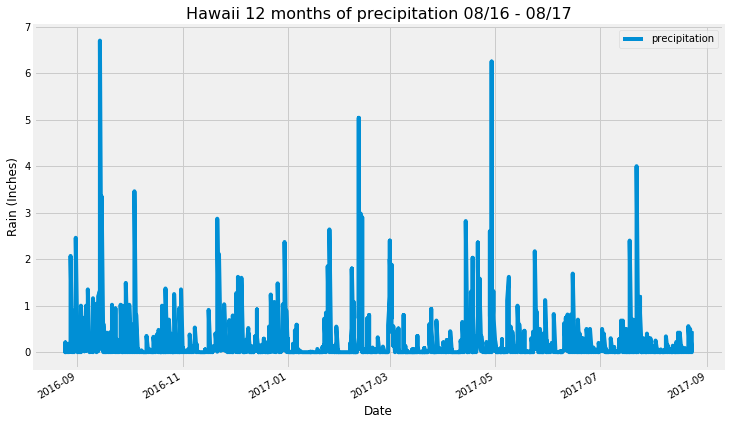

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = subplots()
last_12_df.plot(y = "prcp", use_index= True,figsize=(11,7),legend=True,ax = ax)
plt.xlabel("Date")
plt.ylabel("Rain (Inches)")
plt.title("Hawaii 12 months of precipitation 08/16 - 08/17",size = 16)
ax.legend(["precipitation"]);

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_df.describe()

,prcp
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [15]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to show how many stations are available in this dataset?
station_total = session.query(func.count(Station.station)).all()
station_total

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_list = engine.execute("SELECT station, count(station) FROM Measurement\
                             GROUP BY station ORDER BY count(station) DESC").fetchall()
active_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == active_list[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
highest_temp_station = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == active_list[0][0]).\
                filter(Measurement.date >= '2016-08-24').\
                filter(Measurement.date <= '2017-08-23').all()

highest_temp_station_df = pd.DataFrame(highest_temp_station)
highest_temp_station_df.set_index('station', inplace=True)

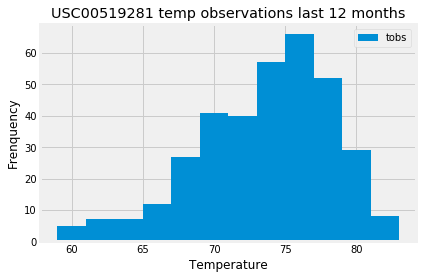

In [20]:
#plot the results as a histogram
fig, ax = subplots(figsize=(6,4))
highest_temp_station_df.hist(bins = 12,ax = ax)
plt.xlabel("Temperature")
plt.ylabel("Frenquency")
plt.title("USC00519281 temp observations last 12 months")
ax.legend(["tobs"])

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2017-07-10'
end = '2017-07-23'
trip_temp = calc_temps(start,end)
print(trip_temp)

[(69.0, 78.36666666666666, 83.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

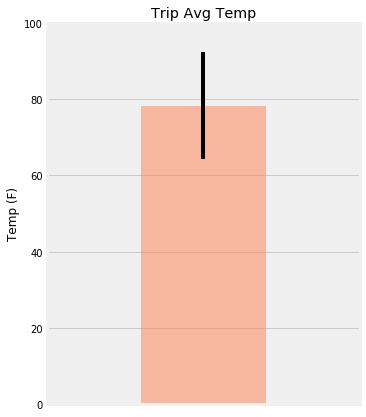

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) vaavg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
min = trip_temp[0][0]
avg = trip_temp[0][1]
max = trip_temp[0][2]
min_max_temp = max - min

fig, ax = plt.subplots(figsize=(5,7))
plt.bar(1,height= avg, yerr = min_max_temp, color='coral',alpha=0.5)
plt.xticks([])
plt.xlim(0,2)
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

each_station_result = session.query(Station.station,func.sum(Measurement.prcp),Station.name, 
                        Station.latitude, Station.longitude,Station.elevation).\
                        filter(Measurement.station == Station.station).\
                        filter(Measurement.date >= start).\
                        filter(Measurement.date <= end).\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

print(each_station_result)

[('USC00516128', 10.690000000000001, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519281', 1.7900000000000003, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00513117', 0.9000000000000001, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00514830', 0.8899999999999999, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 0.44, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519397', 0.25, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]
